#DL4H_Team_38 Final Project - Draft

###**Authors**:
####Eric Chen(echen40), Li-Kai Lin(likaikl2), Peng-Yuan Huang(pyh2)

---
#####Github file link: https://github.com/likaikl2/DLH_Team38_draft/blob/main/DL4H_Team_38.ipynb

# Mount Notebook to Google Drive
Upload the data, pretrianed model, figures, etc to your Google Drive, then mount this notebook to Google Drive. After that, you can access the resources freely.

Instruction: https://colab.research.google.com/notebooks/io.ipynb

Example: https://colab.research.google.com/drive/1srw_HFWQ2SMgmWIawucXfusGzrj1_U0q

Video: https://www.youtube.com/watch?v=zc8g8lGcwQU

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!pip install gdown

!gdown https://drive.google.com/drive/folders/1Ab5KF4r31fQjtotlTgmlvwRqt1RenXCo?usp=sharing -O /content/drive/MyDrive/Colab_Notebooks/Data --folder



Mounted at /content/drive
Retrieving folder contents
Retrieving folder 1O7rsmBB8-SFidRbR-ejNXG9M0MnaICm4 Demo_Data
Processing file 1-4P1mmAt6G9s6G1zt3_aMlA8DVFTKIKO ADMISSIONS.csv
Processing file 1-2XnIL-Z3gfZ-epmokEP4nojfjEk3MGW DIAGNOSES_ICD.csv
Processing file 1-D_v4tc98EjhaKSbuUIXd0Veu8ZKSu_X PATIENTS.csv
Retrieving folder 1c4Vb7c_jI0hjZ-Ayb2hPAPal1XoqBb2P KnowLife
Processing file 1KWmhNaxKNyoPdM7SM723qXOcvney1Dbi entity_embeddings.pt
Processing file 1j5vs-ZP_N7T3Oi0Uu7HVb-pATTyrSJRk entity2id.json
Retrieving folder 1-A0meZdbWtsggcXGH6c2Zh6kPePqOFpp exp1
Processing file 1I596fy4sD7FW1YGfpkXBVH8j8Eldv9bj best.ckpt
Processing file 15N_RrQ-v4w9BHo2H7KYD_IMBM-fKfNtn last.ckpt
Processing file 1-2BEZlFC236HB2fzg0Rcse-unLMmJKms graph.txt
Processing file 1AWNVBHIndwxZ-Zt2T9XnmUhQChklOTB9 knowlife.csv
Processing file 1QYS0tbdYKqooVVU3U5eOBsdZAD_9EDKC relation_embeddings.pt
Processing file 1oa3pInkc_2SFG6aJbmKHxCts8leG_B_e relation2id.json
Retrieving folder 1D0Jhfp1O8RhiO0wNRFuttjdiq31_0CG_ 

# Introduction

The goal of this study is to predict heart failure risk in patients based on their electronic health record (EHR) data. Early identification of high-risk patients could enable timely interventions and improved outcomes. However, accurately predicting heart failure risk remains challenging,
especially when EHR data is limited. This study aims to validate whether the Domain Knowledge Guided Recurrent Neural Networks (DG-RNN) model, which incorporates medical domain knowledge via a knowledge graph and utilizes various architectural components, can outperform existing risk prediction models and provide interpretable results.


# Scope of Reproducibility:

List hypotheses from the paper you will test and the corresponding experiments you will run.

1. Hypothesis 1: Incorporating domain knowledge from a medical knowledge graph (KnowLife) into a deep
learning model (DG-RNN) will significantly improve the performance of clinical risk
prediction compared to models that do not utilize domain knowledge.
2. Hypothesis 2: The dynamic attention mechanism in DG-RNN, which integrates relevant information from
the medical knowledge graph at each step, will contribute to better risk prediction
performance compared to models with static or no attention mechanisms.
3. Hypothesis 3: The global max pooling operation in DG-RNN will not only improve the model's
performance but also enable the interpretation of individual medical event contributions to
the predicted risk.
4. Hypothesis 4: DG-RNN will demonstrate robustness to limited training data, outperforming baseline
models even when the amount of available training data is reduced.
5. Hypothesis 5: The incorporation of time encodings in DG-RNN, which capture the irregular time intervals
between EHR events, will lead to improved risk prediction performance compared to
models that do not consider temporal information.
6. Hypothesis 6: The pre-training of medical concept and relation embeddings using TransE will provide a
meaningful initialization for DG-RNN, contributing to its superior performance.




# Methodology

This methodology is the core of your project. It consists of run-able codes with necessary annotations to show the expeiment you executed for testing the hypotheses.

The methodology at least contains two subsections **data** and **model** in your experiment.

---
The DG-RNN model predicts clinical risk by integrating medical events, time information, and domain knowledge from a medical knowledge graph. The model's inputs include medical event embeddings and corresponding time encoding vectors. Time encodings, similar to positional encodings in Transformer, capture the relative time to the prediction date and intervals between events. The medical event embeddings and time encodings are fed into an LSTM layer, which generates output vectors and hidden states at each step.

A knowledge graph attention module then takes the hidden state and a sub-graph of the medical knowledge graph adjacent to the current event as inputs, producing an attention vector that is fed back into the LSTM. This allows the model to dynamically incorporate relevant domain knowledge for each event. The knowledge graph contains medical concepts and relationships, with embeddings initialized using TransE.

The LSTM output vectors are concatenated and passed through a global max pooling layer, which improves performance and allows for interpretation of individual event contributions. Finally, a fully connected layer produces the clinical risk prediction.

The model's interpretability lies in its ability to compute the contribution of each input event to the final risk prediction by analyzing the max-pooling layer's outputs and the corresponding fully connected layer's outputs. This is achieved through the global max pooling operation, which associates each feature of the final representation with a specific input event.

The training process involves initializing embeddings, iterating through patient EHR data, computing time encodings, performing LSTM and attention operations, and updating parameters based on the prediction loss. The model's objective function is the cross-entropy between the ground truth and the predicted risk probability.


---


Python version

In [2]:
import sys
print("Python version")
print(sys.version)

Python version
3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]


---
Dependencies/packages needed

In [3]:
# import  packages you need
# below imported from the initial section of main.py

# sys.setdefaultencoding('utf8')

import os
import sys
import time
import numpy as np
from sklearn import metrics
import random
import json
import traceback # imported from py_op.py
import collections # imported from data_loader.py
from collections import OrderedDict
from tqdm import tqdm
import warnings # imported from data_loader.py
from copy import deepcopy # imported from data_loader.py

import torch
print(torch.__version__)
from torch.autograd import Variable
from torch.backends import cudnn
from torch.nn import DataParallel
from torch.utils.data import DataLoader
from torch.utils.data import Dataset # imported from data_loader.py
import argparse #imported from parse.py



2.2.1+cu121


---
The py_op module, which is from the file py_op.py, is imported as below and includes additional operations and utilities that support the model's training and evaluation:

In [4]:
# below imported from py_op.py
def mywritejson(save_path,content):
    content = json.dumps(content,indent=4,ensure_ascii=False)
    with open(save_path,'w') as f:
        f.write(content)

def myreadjson(load_path):
    with open(load_path,'r') as f:
        return json.loads(f.read())

from multiprocessing import Pool, Manager
manager = Manager()
matchDict = manager.dict()
def match(src, objs, grade):
        for obj in objs:
            value = fuzz.partial_ratio(src,obj)
            if value > grade:
                matchDict[src] = matchDict.get(src, []) + [[value, obj]]
                if len(matchDict[src]) > 1:
                    print('------------------------------')
        print(len(matchDict))

def myfuzzymatch(srcs,objs,grade=80):
    p = Pool(32)
    for src in list(srcs): # [:100]:
        p.apply_async(match, args=(src, objs, grade))
    p.close()
    p.join()

    new_match = { k:sorted(v, reverse=True) for k,v in matchDict.items() }

    return new_match

def fuzz_list(node1_list,node2_list,score_baseline=66,proposal_num=10,string_map=None):
    node_dict = { }
    for i,node1 in enumerate(node1_list):
        match_score_dict = { }
        for node2 in node2_list:
            if node1 != node2:
                if string_map is not None:
                    n1 = string_map(node1)
                    n2 = string_map(node2)
                    score = fuzz.partial_ratio(n1,n2)
                    if n1 == n2:
                        node2_list.remove(node2)
                else:
                    score = fuzz.partial_ratio(node1,node2)
                if score > score_baseline:
                    match_score_dict[node2] = score
            else:
                node2_list.remove(node2)
        node2_sort = sorted(match_score_dict.keys(), key=lambda k:match_score_dict[k],reverse=True)
        node_dict[node1] = [[n,match_score_dict[n]] for n in node2_sort[:proposal_num]]
        print(i,len(node1_list))
    return node_dict, node2_list



---
The code below contains functions for visualizing the results of the model's predictions, the training process (e.g., loss over epochs), and possibly the attention weights to interpret the model's decision-making process.

* This portion contains utility functions for plotting graphs and visualizations.
* It defines functions like plot_multi_graph and plot_multi_line to plot multiple images or line graphs in a grid layout.

In [5]:
# the code below is imported from plot.py
import matplotlib.pyplot as plt
def plot_multi_graph(image_list, name_list, save_path=None, show=False):
    graph_place = int(np.sqrt(len(name_list) - 1)) + 1
    print('eeee')
    for i, (image, name) in enumerate(zip(image_list, name_list)):
        ax1 = plt.subplot(graph_place,graph_place,i+1)
        ax1.set_title(name)
        # plt.imshow(image,cmap='gray')
        plt.imshow(image)
        plt.axis('off')
        print('eeee')
    if save_path:
        plt.savefig(save_path)
        print('eeee')
        pass
    if show:
        plt.show()

def plot_multi_line(x_list, y_list, name_list, save_path=None, show=False):
    plt.clf()
    graph_place = int(np.sqrt(len(name_list) - 1)) + 1
    for i, (x, y, name) in enumerate(zip(x_list, y_list, name_list)):
        ax1 = plt.subplot(graph_place,graph_place,i+1)
        # ax1 = plt.subplot(1,graph_place,i+1)
        fontsize= 15
        ax1.set_title(name, fontsize=fontsize)
        plt.plot(x,y, markersize=12)

        plt.xticks([-120, -90, -60, -30, -7])
        plt.xlim(-130, 0)
        # plt.imshow(image,cmap='gray')
        plt.xlabel('Hold-Off Window', fontsize=fontsize)
        if i == 0:
            plt.ylabel('Comtribution Rate', fontsize=fontsize)
            plt.ylim(0.855, 0.915)
        else:
            plt.ylim(0.085, 0.145)
    if save_path:
        plt.savefig(save_path+'.eps')
    if show:
        plt.show()


def plot_multi_line_one_image(x_list, y_list, name, save_path=None, show=False):
    plt.clf()
    for i, (x, y) in enumerate(zip(x_list, y_list)):
        ax1 = plt.subplot(1,1,1)
        plt.plot(x,y)
        if i == 0:
            ax1.set_title(name)
            plt.xlabel('Hold-off window')
            plt.ylabel('Comtribution rate')
    if save_path:
        plt.savefig(save_path)
    if show:
        plt.show()

##  **Data**
Data includes raw data (MIMIC III tables), descriptive statistics (our homework questions), and data processing (feature engineering).
  * Source of the data: where the data is collected from; if data is synthetic or self-generated, explain how. If possible, please provide a link to the raw datasets.
  * Statistics: include basic descriptive statistics of the dataset like size, cross validation split, label distribution, etc.
  * Data process: how do you munipulate the data, e.g., change the class labels, split the dataset to train/valid/test, refining the dataset.
  * Illustration: printing results, plotting figures for illustration.
  * You can upload your raw dataset to Google Drive and mount this Colab to the same directory. If your raw dataset is too large, you can upload the processed dataset and have a code to load the processed dataset.

**Please note that in this draft we will be using a smaller dataset which is derived from the original dataset only for demo, as the original one is too large and will take a couple of hours to process.**

In [6]:
!pip install pyhealth

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.6/311.6 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 46.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 46.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.9/140.9 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.

###**Case-control matching**

In this code, we first load the MIMIC-III dataset using the PyHealth library. We define the ICD-9 codes for heart failure and the desired prediction window (120 days in this example).

Next, we identify case patients based on the presence of heart failure diagnosis codes. For each case patient, we find control patients with similar age (within a 5-year range) and gender who do not have a heart failure diagnosis before the index date of the case patient. We randomly select a fixed number of control patients (num_controls) for each case patient and assign them the same index date.

After matching case and control patients, we combine them into a single dataset. We then extract the EHR data for each patient within the specified prediction window.

Finally, we can perform further data preprocessing and feature selection on the matched dataset, such as converting diagnosis codes to a higher-level representation, removing infrequent events, and focusing on diagnosis-related events.

In [7]:
from ast import And
import pyhealth
from pyhealth.datasets import MIMIC3Dataset
import pandas as pd
from sklearn.model_selection import train_test_split

# Specify the root directory of the MIMIC-III dataset
mimic_root = '/content/drive/MyDrive/Colab_Notebooks/Data/Demo_Data'

# Specify the tables to load from the MIMIC-III dataset
mimic_tables = ['DIAGNOSES_ICD']

# Initialize the MIMIC-III dataset
mimic = MIMIC3Dataset(root=mimic_root, tables=mimic_tables)

# Define the ICD-9 codes for heart failure (HF)
hf_codes = [
    '428', '4280', '4281', '4282', '42820', '42821', '42822', '42823',
    '4283', '42830', '42831', '42832', '42833', '4284', '42840', '42841',
    '42842', '42843', '4289', '40201', '40211', '40291', '40401', '40403',
    '40411', '40413', '40491', '40493'
]

# Define the number of controls per case
num_controls = 3

# Initialize an empty dictionary to store patients' data
patients_data = {}

patients_data = mimic.parse_basic_info(patients_data)
patients_data = mimic.parse_diagnoses_icd(patients_data)


# Create a list to store the case and control patients
case_patients = []
control_patients = []

# print(patients_data[list(patients_data.keys())[1]])

# Iterate over each patient in the patients_data dictionary
for patient_id, patient_info in patients_data.items():
    # Get the patient's visits
    visits = patient_info.visits

    # Check if the patient has heart failure diagnosis
    for visit_id, visit in visits.items():
        for diagnosis in visit.get_code_list('DIAGNOSES_ICD'):
            if diagnosis in hf_codes:
                case_patients.append(patient_id)
            else:
                control_patients.append(patient_id)

max_year = 0

for case_patient_id in case_patients:
    if patients_data[case_patient_id].death_datetime is not None and patients_data[case_patient_id].death_datetime.year > max_year:
        max_year = patients_data[case_patient_id].death_datetime.year


# Create a list to store the matched control patients
matched_controls = []
matched_control_patients = []

# Iterate over each case patient
for case_patient_id in case_patients:
    # Get the case patient's age and gender
    if patients_data[case_patient_id].death_datetime is None:
        case_age = max_year - patients_data[case_patient_id].birth_datetime.year
    else:
        case_age = patients_data[case_patient_id].death_datetime.year - patients_data[case_patient_id].birth_datetime.year

    case_gender = patients_data[case_patient_id].gender

    # Find control patients with similar age and gender
    # Temporarily disable the age filter for smaller dataset. This filter will be
    # re-enabled in the formal final report.
    for patient_id in control_patients:
        # if patients_data[patient_id].death_datetime is None:
        #     patient_age = max_year - patients_data[patient_id].birth_datetime.year
        # else:
        #     patient_age = patients_data[patient_id].death_datetime.year - patients_data[patient_id].birth_datetime.year
        if (
            # patient_age >= case_age - 5 and
            # patient_age <= case_age + 5 and
            patients_data[patient_id].gender == case_gender
        ):
            matched_control_patients.append(patient_id)

    # Randomly select num_controls control patients
    selected_controls = pd.Series(matched_control_patients).sample(n=num_controls, random_state=42)

    # Add the selected control patients to the matched controls list
    matched_controls.extend(selected_controls)

# Combine case patients and matched control patients
case_control_patient_ids = case_patients + matched_controls

# Create a new dictionary with case-control patients' data
case_control_patients_data = {patient_id: patients_data[patient_id] for patient_id in case_control_patient_ids}

INFO: Pandarallel will run on 1 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


finish basic patient information parsing : 0.704535961151123s


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


finish parsing DIAGNOSES_ICD : 0.4002063274383545s


Mapping codes: 100%|██████████| 93/93 [00:00<00:00, 108022.78it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


###**Data Extraction**

In this code:

1. Since we have already performed case-control matching and obtained the matched patient IDs, which are stored in the `case_control_patient_ids` list, we first list all IDs in the `case_control_patient_ids`.
2. We initialize an empty dictionary called `extracted_data` to store the extracted data for each matched patient.
3. We iterate over each matched patient ID and extract the relevant information:
  - Basic patient information (age and gender) is extracted from the patients_data dictionary.
  - Diagnoses, procedures, prescriptions, and lab events are extracted from the patient's visits in the `patients_data` dictionary.
5. The extracted data for each patient is appended to the corresponding lists in the `extracted_data` dictionary.
6. After extracting data for all matched patients, we convert the `extracted_data` dictionary into a pandas DataFrame called `extracted_df`.
7. Finally, we save the extracted data to a file (e.g., CSV) using the `to_csv()` method of the `DataFrame`.

In [8]:
# Initialize an empty dictionary to store the extracted data
extracted_data = {
    'patient_id': [],
    'age': [],
    'gender': [],
    'diagnoses': [],
    'is_case': []
}


# Iterate over each matched patient ID
for patient_id in case_control_patient_ids:
    # Get the patient's basic information
    patient_info = patients_data[patient_id]

    # Extract age and gender
    if patient_info.death_datetime is None:
        age = max_year - patient_info.birth_datetime.year
    else:
        age = patient_info.death_datetime.year - patient_info.birth_datetime.year
    gender = patient_info.gender

    is_case = []

    # Extract diagnoses
    diagnoses = []
    for visit_id, visit in patient_info.visits.items():
        for diagnosis in visit.get_code_list('DIAGNOSES_ICD'):
            if diagnosis in hf_codes:
                is_case.append('1')
            else:
                is_case.append('0')
            diagnoses.append(diagnosis)

    # Append the extracted data to the dictionary
    extracted_data['patient_id'].append(patient_id)
    extracted_data['age'].append(age)
    extracted_data['gender'].append(gender)
    extracted_data['diagnoses'].append(diagnoses)
    extracted_data['is_case'].append(is_case[0])

# Convert the extracted data into a pandas DataFrame
extracted_df = pd.DataFrame(extracted_data)

# Perform further data preprocessing, feature engineering, and analysis on the extracted DataFrame
# ...

# Save the extracted data to a file if needed
extracted_df.to_json('/content/drive/MyDrive/Colab_Notebooks/Data/Pre-Processed/extracted_data.json', orient='records')

###**Feature Selection**

In this code:

1. We define the feature columns and the target variable. In this example, we assume that the target variable is a binary variable indicating whether a patient is a case (1) or control (0), and it is stored in the `is_case` column of the DataFrame.
2. We convert the target variable to binary labels using `astype(int)`.
3. We perform one-hot encoding for categorical features (`gender`, `diagnoses`, `procedures`, `prescriptions`, `lab_events`) using `pd.get_dummies()`. This creates binary columns for each unique category in these features.
4. We combine the encoded categorical features with the numerical feature (`age`) using `pd.concat()` to create the feature matrix `X`. The target variable `y` is extracted separately.
5. We perform feature selection using the `SelectKBest` class from scikit-learn with the chi-square test as the scoring function. We specify the desired number of top features to select using the `k` parameter.
6. We fit and transform the feature matrix `X` using the `fit_transform()` method of the `SelectKBest` object, which selects the top `k` features based on their chi-square test scores.
7. We retrieve the names of the selected features using the `get_support()` method of the `SelectKBest` object and the column names of `X`.
8. We create a new `DataFrame` `selected_df` with the selected features and the target variable using `pd.concat()`.
9. Finally, we save the selected features and target variable to a file (e.g., CSV) using the `to_csv()` method of the DataFrame.

In [9]:
from sklearn.feature_selection import SelectKBest, chi2

# Define the feature columns and target variable
feature_columns = ['age', 'gender', 'diagnoses']
target_variable = 'is_case'

# Convert the target variable to binary labels
extracted_df[target_variable] = extracted_df[target_variable].astype(int)

# Convert list columns to string representations
extracted_df['diagnoses'] = extracted_df['diagnoses'].apply(lambda x: ','.join(map(str, x)))

# Perform one-hot encoding for categorical features
categorical_features = ['gender', 'diagnoses']
encoded_features = pd.get_dummies(extracted_df[categorical_features], prefix_sep='_')

# Combine the encoded features with the numerical features
X = pd.concat([extracted_df[['age']], encoded_features], axis=1)
y = extracted_df[target_variable]

# Perform feature selection using SelectKBest with chi-square test
k = 'all'  # Select all available features
selector = SelectKBest(score_func=chi2, k=k)
X_selected = selector.fit_transform(X, y)

# Get the selected feature names
selected_feature_names = X.columns[selector.get_support()].tolist()

# Create a new DataFrame with the selected features and target variable
selected_df = pd.concat([pd.DataFrame(X_selected, columns=selected_feature_names), y], axis=1)

# Perform further data preprocessing, model training, and evaluation on the selected features
# ...

# Save the selected features and target variable to a file if needed
selected_df.to_json('/content/drive/MyDrive/Colab_Notebooks/Data/Pre-Processed/selected_features.json', orient='records')

###**Data Representation**

In this code:

1. We separate the features (`X`) and the target variable (`y`) from the `selected_df` DataFrame.
2. We convert the data to PyTorch tensors using `torch.tensor()`. The features are converted to float32 tensors, and the target variable is converted to float32 tensors and reshaped to have an additional dimension using `unsqueeze(1)`.
3. We define a data representation model (`DataRepresentationModel`) using PyTorch's `nn.Module`. This model consists of two fully connected layers with a ReLU activation function in between. The model takes the input features and learns a lower-dimensional representation.
4. We set the model parameters, including the input dimension (`input_dim`), hidden dimension (`hidden_dim`), and output dimension (`output_dim`). You can adjust these values based on your specific requirements.
5. We create an instance of the data representation model using the specified parameters.
6. We define the loss function (`nn.MSELoss()`) and the optimizer (`torch.optim.Adam`) for training the model.
7. We set the number of training epochs (`num_epochs`) and start the training loop.
8. Inside the training loop, we perform a forward pass to obtain the model outputs, calculate the loss, perform a backward pass to compute gradients, and update the model parameters using the optimizer.
9. We print the loss every 10 epochs to monitor the training progress.
10. After training, we obtain the learned data representation by passing the input features through the trained model and detaching the output from the computation graph using `detach()`.
11. We create a new DataFrame (`representation_df`) with the learned data representation, where each column represents a learned feature.
12. Finally, we save the learned data representation to a file (e.g., CSV) using the `to_csv()` method of the DataFrame.

In [10]:
import torch.nn as nn

# Separate features and target variable
X = selected_df.drop('is_case', axis=1)
y = selected_df['is_case']

# Convert data to PyTorch tensors
X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)

# Define the data representation model
class DataRepresentationModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DataRepresentationModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Set the model parameters
input_dim = X_tensor.shape[1]
hidden_dim = 100
output_dim = 50

# Create an instance of the data representation model
model = DataRepresentationModel(input_dim, hidden_dim, output_dim)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Set the number of training epochs
num_epochs = 100

# Training loop
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_tensor)
    loss = criterion(outputs, y_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print the loss for every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Get the learned data representation
data_representation = model(X_tensor).detach().numpy()

# Create a new DataFrame with the learned data representation and target variable
representation_df = pd.DataFrame(data_representation, columns=[f'feature_{i}' for i in range(output_dim)])
representation_df['is_case'] = y


# Perform further analysis or use the learned data representation for downstream tasks
# ...

# Save the learned data representation to a file if needed
representation_df.to_json('/content/drive/MyDrive/Colab_Notebooks/Data/Pre-Processed/data_representation.json', orient='records')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 1])) that is different to the input size (torch.Size([8, 50])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 16.8550
Epoch [20/100], Loss: 3.3007
Epoch [30/100], Loss: 2.2679
Epoch [40/100], Loss: 0.7874
Epoch [50/100], Loss: 0.4695
Epoch [60/100], Loss: 0.3148
Epoch [70/100], Loss: 0.2530
Epoch [80/100], Loss: 0.2418
Epoch [90/100], Loss: 0.2291
Epoch [100/100], Loss: 0.2259


###**Data Split**

In this code:

1. We separate the features (`X`) and the target variable (`y`) from the `final_df` DataFrame.
2. We split the data into training, validation, and testing sets using the `train_test_split()` function from `scikit-learn`. We first split the data into training and temporary sets with a test size of 0.3 (i.e., 30% of the data). Then, we further split the temporary set into validation and testing sets with a test size of 0.5 (i.e., 50% of the temporary set). We use stratified splitting by specifying `stratify=y` to ensure that the class distribution is maintained in each split.
3. We convert the split data to PyTorch tensors using `torch.tensor()`. The features are converted to `float32` tensors, and the target variable is converted to `float32` tensors and reshaped to have an additional dimension using `unsqueeze(1)`.
4. We create PyTorch datasets using `torch.utils.data.TensorDataset()` for the training, validation, and testing splits. Each dataset is created by passing the corresponding feature and target tensors.
5. We create PyTorch dataloaders using `torch.utils.data.DataLoader()` for the training, validation, and testing datasets. The dataloaders allow for efficient batch-wise data loading and shuffling during training. We can specify the batch size and whether to shuffle the data using the `batch_size` and shuffle parameters.
6. Finally, we save the split datasets to files using `torch.save()`. This allows us to load the datasets directly in the future without repeating the splitting process.

In [11]:
from sklearn.model_selection import train_test_split

# Assuming you have already performed case-control matching, data extraction, feature selection, data representation, and obtained the final DataFrame
final_df = representation_df  # Final DataFrame after case-control matching, data extraction, feature selection, and data representation

# Separate features and target variable
X = final_df.drop('is_case', axis=1)
y = final_df['is_case']

# This section could probably be removed with larger dataset.
# Remove samples with the minority class
minority_class = y.value_counts().idxmin()
mask = y != minority_class
X = X[mask]
y = y[mask]

# Split the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Create DataFrames for each split
train_df = pd.concat([X_train, y_train], axis=1)
val_df = pd.concat([X_val, y_val], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

# Save the split datasets to JSON files
train_df.to_json('/content/drive/MyDrive/Colab_Notebooks/Data/train.json', orient='records')
val_df.to_json('/content/drive/MyDrive/Colab_Notebooks/Data/valid.json', orient='records')
test_df.to_json('/content/drive/MyDrive/Colab_Notebooks/Data/test.json', orient='records')

#### KnowLife Preprocessing

In [12]:
import os
import pandas as pd
import pyhealth
import string
from pyhealth.medcode import CrossMap

process_graph = False

if process_graph:

    knowlife_path = '/content/drive/MyDrive/Colab_Notebooks/Data/KnowLife/'
    input_file = 'knowlife.csv'
    output_file = 'graph.txt'

    # UMLS to ICD9CM tools
    translator = str.maketrans('', '', string.punctuation)
    mapping = CrossMap("UMLS", "ICD9CM")

    # Read file and filter out rows where relation != causes and correct != t
    df = pd.read_csv(knowlife_path + input_file, header=0, names=['head','relation','tail','correct'])
    df = df.loc[(df['correct']=='t') & (df['relation']=='causes')].drop(columns=['correct'])

    # Map UMLS to ICD9CM
    df['head'] = df['head'].apply(lambda c: mapping.map(c))
    df['tail'] = df['tail'].apply(lambda c: mapping.map(c))

    # Turn many-to-many mappings to one-to-one mappings
    df = df.explode('head').explode('tail')

    # Drop rows without mapping
    df = df.dropna()

    # Remove periods/punctuation from ICD9CM
    df['head'] = df['head'].apply(lambda c: c.translate(translator))
    df['tail'] = df['tail'].apply(lambda c: c.translate(translator))

    # Create is-caused-by graph and concatenate with causes graph
    df_reverse = df.copy()
    df_reverse['head'], df_reverse['tail'] = df_reverse['tail'], df_reverse['head']
    df_reverse['relation'] = 'is-caused-by'
    df = pd.concat([df,df_reverse]).drop_duplicates()

    # Write to drive
    df.to_csv(knowlife_path + output_file, sep='\t', header=False, index=False)

####KnowLife Embedding Generation

In [13]:
# Taken from https://github.com/sunlabuiuc/PyHealth/blob/4febba6061253c4c178fa035d2afa67e206fc9a8/pyhealth/medcode/pretrained_embeddings/kg_emb/examples/train_kge_model.py
from pyhealth.medcode.pretrained_embeddings.kg_emb.datasets import UMLSDataset, split
from pyhealth.medcode.pretrained_embeddings.kg_emb.tasks import link_prediction_fn
from pyhealth.datasets import get_dataloader
from pyhealth.medcode.pretrained_embeddings.kg_emb.models import TransE
from pyhealth.trainer import Trainer
from pyhealth.medcode import InnerMap
import torch
import json
import pickle

generate_embedding = False
load_best_checkpoint = True
load_last_checkpoint = False

if generate_embedding:

    knowlife_path = '/content/drive/MyDrive/Colab_Notebooks/Data/KnowLife/'
    experiment = 'exp1'

    # dataset is KnowLife even though we used UMLSDataset class
    ds = UMLSDataset(root=knowlife_path, dev=False)

    # check the dataset statistics before setting task
    print(ds.stat())

    # check the relation numbers in the dataset
    print("Relations in KG:", ds.relation2id)

    ds = ds.set_task(link_prediction_fn, negative_sampling=64, save=False)

    # check the dataset statistics after setting task
    print(ds.stat())

    # split the dataset and get the dataloaders
    train_dataset, val_dataset, test_dataset = split(ds, [0.8, 0.1, 0.1])
    train_loader = get_dataloader(train_dataset, batch_size=8, shuffle=True)
    val_loader = get_dataloader(val_dataset, batch_size=2, shuffle=False)
    test_loader = get_dataloader(test_dataset, batch_size=2, shuffle=False)

    # initialize TransE model
    model = TransE(dataset=ds, e_dim=512, r_dim=512)

    if load_best_checkpoint:
        # load best checkpoint
        state_dict = torch.load(knowlife_path + experiment + "/best.ckpt")
        model.load_state_dict(state_dict)
        print('Loaded best checkpoint: ', model)
    else:
        # load last checkpoint
        if load_last_checkpoint:
            state_dict = torch.load(knowlife_path + experiment + "/last.ckpt")
            model.load_state_dict(state_dict)
            print('Loaded last checkpoint: ', model)

        # train model
        trainer = Trainer(
            model=model,
            device="cuda",
            metrics=['hits@n', 'mean_rank'],
            output_path=knowlife_path,
            exp_name=experiment
        )

        trainer.train(
            train_dataloader=train_loader,
            val_dataloader=val_loader,
            epochs=200,
            optimizer_params={'lr': 1e-3},
            monitor='mean_rank',
            monitor_criterion='min'
        )

        # evaluate model
        trainer.evaluate(test_loader)

    # save entity2id and relation2id
    with open(knowlife_path + experiment + "/entity2id.json", "w") as f:
        json.dump(ds.entity2id, f, indent=4)
    with open(knowlife_path + experiment + "/relation2id.json", "w") as f:
        json.dump(ds.relation2id, f, indent=4)

    # save entity and relation embeddings
    torch.save(model.E_emb, knowlife_path + experiment + "/entity_embeddings.pt")
    torch.save(model.R_emb, knowlife_path + experiment + "/relation_embeddings.pt")


#### UMLS Preprocessing

In [14]:
import os
import pandas as pd
import pyhealth
import string
from pyhealth.medcode import CrossMap

process_graph = False

if process_graph:

    umls_path = '/content/drive/MyDrive/Colab_Notebooks/Data/UMLS/'
    input_file = 'MRREL.RRF.zip'
    output_file = 'graph.txt'

    # UMLS to ICD9CM tools
    translator = str.maketrans('', '', string.punctuation)
    mapping = CrossMap("UMLS", "ICD9CM")

    # Read file and filter out rows where relation != cause_of
    df = pd.read_csv(umls_path + input_file, sep='|', header=None, usecols=[0,4,7], dtype='string')
    df.columns = ['tail','head','relation']
    df = df[['head','relation','tail']]
    df = df.loc[df['relation'] == 'cause_of']
    df['relation'] = 'causes'

    # Map UMLS to ICD9CM
    df['head'] = df['head'].apply(lambda c: mapping.map(c))
    df['tail'] = df['tail'].apply(lambda c: mapping.map(c))

    # Turn many-to-many mappings to one-to-one mappings
    df = df.explode('head').explode('tail')

    # Drop rows without mapping
    df = df.dropna()

    # Remove periods/punctuation from ICD9CM
    df['head'] = df['head'].apply(lambda c: c.translate(translator))
    df['tail'] = df['tail'].apply(lambda c: c.translate(translator))

    # Create is-caused-by graph and concatenate with causes graph
    df_reverse = df.copy()
    df_reverse['head'], df_reverse['tail'] = df_reverse['tail'], df_reverse['head']
    df_reverse['relation'] = 'is-caused-by'
    df = pd.concat([df,df_reverse]).drop_duplicates()

    # Write to drive
    df.to_csv(umls_path + output_file, sep='\t', header=False, index=False)

####UMLS Embedding Generation

In [15]:
# Taken from https://github.com/sunlabuiuc/PyHealth/blob/4febba6061253c4c178fa035d2afa67e206fc9a8/pyhealth/medcode/pretrained_embeddings/kg_emb/examples/train_kge_model.py
from pyhealth.medcode.pretrained_embeddings.kg_emb.datasets import UMLSDataset, split
from pyhealth.medcode.pretrained_embeddings.kg_emb.tasks import link_prediction_fn
from pyhealth.datasets import get_dataloader
from pyhealth.medcode.pretrained_embeddings.kg_emb.models import TransE
from pyhealth.trainer import Trainer
from pyhealth.medcode import InnerMap
import torch
import json

generate_embedding = False
load_best_checkpoint = True
load_last_checkpoint = False

if generate_embedding:

    umls_path = '/content/drive/MyDrive/Colab_Notebooks/Data/UMLS/'
    experiment = 'exp1'

    # dataset is KnowLife even though we used UMLSDataset class
    ds = UMLSDataset(root=umls_path, dev=False)

    # check the dataset statistics before setting task
    print(ds.stat())

    # check the relation numbers in the dataset
    print("Relations in KG:", ds.relation2id)

    ds = ds.set_task(link_prediction_fn, negative_sampling=64, save=False)

    # check the dataset statistics after setting task
    print(ds.stat())

    # split the dataset and get the dataloaders
    train_dataset, val_dataset, test_dataset = split(ds, [0.8, 0.1, 0.1])
    train_loader = get_dataloader(train_dataset, batch_size=8, shuffle=True)
    val_loader = get_dataloader(val_dataset, batch_size=2, shuffle=False)
    test_loader = get_dataloader(test_dataset, batch_size=2, shuffle=False)

    # initialize TransE model
    model = TransE(dataset=ds, e_dim=512, r_dim=512)

    if load_best_checkpoint:
        # load best checkpoint
        state_dict = torch.load(umls_path + experiment + "/best.ckpt")
        model.load_state_dict(state_dict)
        print('Loaded best checkpoint: ', model)
    else:
        # load checkpoint
        if load_last_checkpoint:
            state_dict = torch.load(umls_path + experiment + "/last.ckpt")
            model.load_state_dict(state_dict)
            print('Loaded last checkpoint: ', model)

        # train model
        trainer = Trainer(
            model=model,
            device="cuda",
            metrics=['hits@n', 'mean_rank'],
            output_path=umls_path,
            exp_name=experiment
        )

        trainer.train(
            train_dataloader=train_loader,
            val_dataloader=val_loader,
            epochs=400,
            optimizer_params={'lr': 1e-3},
            monitor='mean_rank',
            monitor_criterion='min'
        )

        # evaluate model
        trainer.evaluate(test_loader)

    # save entity2id and relation2id
    with open(umls_path + experiment + "/entity2id.json", "w") as f:
        json.dump(ds.entity2id, f, indent=4)
    with open(umls_path + experiment + "/relation2id.json", "w") as f:
        json.dump(ds.relation2id, f, indent=4)

    # save entity and relation embeddings
    torch.save(model.E_emb, umls_path + experiment + "/entity_embeddings.pt")
    torch.save(model.R_emb, umls_path + experiment + "/relation_embeddings.pt")


## Dataset

In [16]:
import json
import pyhealth
from pyhealth.datasets import MIMIC3Dataset
from collections import defaultdict
from pyhealth.tasks import mortality_prediction_mimic3_fn

# Specify the root directory of the MIMIC-III dataset
mimic_root = '/content/drive/MyDrive/Colab_Notebooks/Data/MIMIC-III'

# Initialize the MIMIC-III dataset
mimic = MIMIC3Dataset(root=mimic_root, tables=mimic_tables)


# build icd2idx
icds = defaultdict(int)
for patient in mimic.patients.values():
    for visit in patient.visits.values():
        for code in visit.get_code_list(table='DIAGNOSES_ICD'):
            icds[code] += 1

with open('/content/drive/MyDrive/Colab_Notebooks/Data/UMLS/entity2id.json', 'r') as f:
    icd2idx = json.load(f)

idx = len(icd2idx)
for code, freq in icds.items():
    # ignore codes that appear less than 10 times
    if code not in icd2idx and freq >= 10:
        icd2idx[code] = idx
        idx += 1
idx2icd = {id: c for c, id in icd2idx.items()}

# need to do case control matching
total_case, total_control = 0, 0
max_case, max_control = 425, 1275

# define heart failure task
def heart_failure_task(patient):

    global total_case
    global total_control

    if total_case == max_case and total_control == max_control:
        return []

    samples, conditions, masks = [], [], []
    min_length, max_length = 10, 20
    heart_failure = 0

    for visit in patient.visits.values():
        for code in visit.get_code_list(table='DIAGNOSES_ICD'):
            if code in hf_codes:
                heart_failure = 1
                break
            elif code in icd2idx:
                # need to add timestamp later
                conditions.append(icd2idx[code])
                masks.append(1)

        if heart_failure:
            break


    # select cases with 10 to 20 medical codes
    if len(conditions) >= min_length:
        if len(conditions) > max_length:
            conditions = conditions[-max_length:]
            masks = masks[-max_length:]
        else:
            conditions += [0] * (max_length - len(conditions))
            masks += [0] * (max_length - len(masks))

        if heart_failure and total_case < max_case:
            # new case
            samples.append(
                {
                    "visit_id": visit.visit_id,
                    "patient_id": patient.patient_id,
                    "conditions": conditions,
                    "masks": masks,
                    "label": heart_failure,
                }
            )
            total_case += 1
        elif not heart_failure and total_control < max_control:
            # new control
            samples.append(
                {
                    "visit_id": visit.visit_id,
                    "patient_id": patient.patient_id,
                    "conditions": conditions,
                    "masks": masks,
                    "label": heart_failure,
                }
            )
            total_control += 1

    return samples


mimic_samples = mimic.set_task(heart_failure_task)
mimic_samples.stat()

INFO: Pandarallel will run on 1 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


finish basic patient information parsing : 130.43499898910522s


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


finish parsing DIAGNOSES_ICD : 81.39667797088623s


Generating samples for heart_failure_task: 100%|██████████| 46520/46520 [00:00<00:00, 153337.84it/s]

Statistics of sample dataset:
	- Dataset: MIMIC3Dataset
	- Task: heart_failure_task
	- Number of samples: 1700
	- Number of patients: 1700
	- Number of visits: 1700
	- Number of visits per patient: 1.0000
	- conditions:
		- Number of conditions per sample: 1.0000
		- Length of conditions: 20
	- masks:
		- Number of masks per sample: 1.0000
		- Length of masks: 20
	- label:
		- Number of label per sample: 1.0000
		- Number of unique label: 2
		- Distribution of label (Top-10): [(0, 1275), (1, 425)]


'Statistics of sample dataset:\n\t- Dataset: MIMIC3Dataset\n\t- Task: heart_failure_task\n\t- Number of samples: 1700\n\t- Number of patients: 1700\n\t- Number of visits: 1700\n\t- Number of visits per patient: 1.0000\n\t- conditions:\n\t\t- Number of conditions per sample: 1.0000\n\t\t- Length of conditions: 20\n\t- masks:\n\t\t- Number of masks per sample: 1.0000\n\t\t- Length of masks: 20\n\t- label:\n\t\t- Number of label per sample: 1.0000\n\t\t- Number of unique label: 2\n\t\t- Distribution of label (Top-10): [(0, 1275), (1, 425)]'

In [17]:
from pyhealth.datasets.splitter import split_by_sample
from pyhealth.datasets import get_dataloader
# split into train, val, test
train_dataset, val_dataset, test_dataset = split_by_sample(mimic_samples, [0.8, 0.1, 0.1])

# create dataloaders
train_loader = get_dataloader(train_dataset, batch_size=64, shuffle=True)
val_loader = get_dataloader(val_dataset, batch_size=64, shuffle=False)
test_loader = get_dataloader(test_dataset, batch_size=64, shuffle=False)

##   **Model**
The model includes the model definitation which usually is a class, model training, and other necessary parts.

---
1, Model architecture:
* The model portion is imported mainly from original model.py file. The model is defined in the FCModel class, which inherits from nn.Module.
* The model consists of an embedding layer  to map medical events to dense vectors.
* It uses an LSTM (LSTMCore) as the core component to process the sequence of embedded medical events.
* The LSTM core has a configurable hidden size
* The model includes attention mechanisms:
Knowledge graph attention to attend to relevant entities in the knowledge graph.

The model uses fully connected linear layers (nn.Linear) to transform the LSTM outputs and generate predictions.
Activation functions used include ReLU (F.relu) and sigmoid (nn.Sigmoid).

2, Training objectives:
* The loss function is binary cross-entropy loss (nn.BCELoss)

3, Others:
* The model uses pre-trained embeddings for medical entities and relations, loaded from entity_embeddings.pt and relation_embeddings.pt

In [18]:
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

from collections import defaultdict

# below imported from model.py

def _cuda(tensor):
    if args.gpu:
        return tensor.cuda(non_blocking=True) # revised code
    else:
        return tensor

class LSTMCore(nn.Module):
    def __init__(self, input_size, hidden_size, dropout):
        super(LSTMCore, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout

        # Build a LSTM
        self.i2h = nn.Linear(self.input_size, 4 * self.hidden_size)
        self.h2h = nn.Linear(self.hidden_size, 4 * self.hidden_size)

    def forward(self, xt, state):
        # add time encodings

        prev_h, prev_c = state

        all_input_sums = self.i2h(xt) + self.h2h(prev_h)
        sigmoid_chunk = all_input_sums.narrow(1, 0, 3 * self.hidden_size)
        sigmoid_chunk = F.sigmoid(sigmoid_chunk)
        in_gate = sigmoid_chunk.narrow(1, 0, self.hidden_size)
        forget_gate = sigmoid_chunk.narrow(1, self.hidden_size, self.hidden_size)
        out_gate = sigmoid_chunk.narrow(1, self.hidden_size * 2, self.hidden_size)

        in_transform = all_input_sums.narrow(1, 3 * self.hidden_size, self.hidden_size)
        next_c = in_transform * in_gate + forget_gate * prev_c
        next_h = out_gate * F.tanh(next_c)

        state = (next_h, next_c)
        output = next_h

        return output, state

class FCModel(nn.Module):
    def __init__(self):
        super(FCModel, self).__init__()
        ### === settings ===
        self.graph_data_path = '/content/drive/MyDrive/Colab_Notebooks/Data/UMLS/'
        self.load_pretrained_embeddings = True
        self.use_knowledge_graph = True
        self.use_graph_attention = True
        self.use_global_pooling = True

        self.embedding_size = 512
        self.rnn_hidden_size = 512
        self.rnn_dropout = 0.5
        self.vocab = icd2idx

        self.core = LSTMCore(self.embedding_size, self.rnn_hidden_size, self.rnn_dropout)
        self.embed = nn.Embedding(len(self.vocab) , self.embedding_size)
        self.logit = nn.Linear(self.rnn_hidden_size, 1, False)

        ### === knowledge graph ===

        # load entities
        with open(self.graph_data_path + "entity2id.json", "r") as f:
            self.entity2id = json.load(f)
        self.id2entity = {id: e for e, id in self.entity2id.items()}

        # load relations
        with open(self.graph_data_path + "relation2id.json", "r") as f:
            self.relation2id = json.load(f)
        self.id2relation = {id: r for r, id in self.relation2id.items()}

        # load graph
        self.graph = defaultdict(list)
        with open(self.graph_data_path + "graph.txt", "r") as f:
            csv_f = csv.reader(f, delimiter='\t')
            for line in csv_f:
                head, relation, tail = line
                self.graph[self.entity2id[head]].append([self.entity2id[head],self.entity2id[tail],self.relation2id[relation]])

        # initialize graph parameters
        self.wr = nn.Linear(self.embedding_size, self.embedding_size)
        self.wh = nn.Linear(self.embedding_size, self.embedding_size)
        self.wa = nn.Linear(self.embedding_size, self.embedding_size)
        self.wt = nn.Linear(self.embedding_size, self.embedding_size)
        self.ent_embeddings = nn.Embedding(len(self.entity2id), self.embedding_size)
        self.rel_embeddings = nn.Embedding(len(self.relation2id), self.embedding_size)

        ### === initialize weights ===
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.embed.weight.data.uniform_(-initrange, initrange)
        self.logit.weight.data.uniform_(-initrange, initrange)

        # initialize embedding weights
        if self.load_pretrained_embeddings:
            self.ent_embeddings = nn.Embedding.from_pretrained(torch.load(self.graph_data_path + "entity_embeddings.pt"))
            self.rel_embeddings = nn.Embedding.from_pretrained(torch.load(self.graph_data_path + "relation_embeddings.pt"))
        else:
            self.ent_embeddings.weight.data.uniform_(-initrange, initrange)
            self.rel_embeddings.weight.data.uniform_(-initrange, initrange)

    def kg_attention(self, index, c):

        relations = self.graph[index]

        if len(relations) > 0:
            if self.use_graph_attention:
                # dynamic attention
                head_embeddings = self.embed(relations[:,0])
                tail_embeddings = self.ent_embeddings(relations[:,1])
                relation_embeddings = self.rel_embeddings(relations[:,2])

                beta = torch.sum(self.wr(relations) * (F.tanh(self.wh(head_embeddings) + self.wa(c) + self.wt(tail_embeddings))), dim=1)
                alpha = F.softmax(beta)
                gt = torch.mm(alpha, tail_embeddings)

            else:
                # static
                gt = torch.mean(self.ent_embeddings(relations[:,1]), dim=0)

        else:
            # not present in graph
            gt = torch.zeros((self.embedding_size), dtype=torch.float32)

        return gt


    def forward(self, input, mask, label=None):

        # initialize
        batch_size = input.size(0)
        seq_length = input.size(1)
        state = (
            torch.zeros((batch_size,self.embedding_size), dtype=torch.float32).to(device),
            torch.zeros((batch_size,self.embedding_size), dtype=torch.float32).to(device)
        )
        outputs = []
        outputs_kg = []

        # run dg-rnn
        for i in range(seq_length):
            it = input[:, i]
            xt = self.embed(it)

            out, state = self.core(xt, state)
            outputs.append(out)

            # run dynamic attention on knowledge graph
            if self.use_knowledge_graph:
                h, c = state
                gt = []
                for j, code in enumerate(it):
                    gt.append(self.kg_attention(code, c[j]))
                gt = torch.stack(gt).to(device)

                out, state = self.core(gt, state)
                outputs_kg.append(out)

        outputs = torch.stack(outputs,dim=1)
        if self.use_knowledge_graph:
            outputs_kg = torch.stack(outputs_kg,dim=1)

        # collapse with mask
        mask = mask.unsqueeze(-1).expand(batch_size, seq_length, self.embedding_size)
        if self.use_knowledge_graph:
            outputs_kg = outputs_kg * mask
            if self.use_global_pooling:
                outputs_kg = outputs_kg.max(dim=1)[0]
            else:
                outputs_kg = outputs_kg[:, -1, :]
        else:
            outputs = outputs * mask
            if self.use_global_pooling:
                outputs = outputs.max(dim=1)[0]
            else:
                outputs = outputs[:, -1, :]

        output = F.sigmoid(self.logit(outputs_kg if self.use_knowledge_graph else outputs))

        return output


        # calculate contributions



## Training and Validation

Below we start training:
* This portion handles the training and testing process of the model.
* The train function is responsible for training the model, while the test * function evaluates the model on the validation set.
* The main function orchestrates the overall process, including data loading, model initialization, training, and testing.

In [19]:
from sklearn.metrics import roc_auc_score

def evaluate(net, loader):

    net.eval()
    y_score = torch.Tensor()
    y_true = torch.LongTensor()
    for batch in loader:
        conditions = torch.tensor(batch['conditions']).to(device)
        masks = torch.tensor(batch['masks'], dtype=torch.bool).to(device)
        label = torch.tensor(batch['label'], dtype=torch.float32)

        y = net(conditions, masks).view(-1)

        y_score = torch.cat((y_score, y.detach().to('cpu')), dim=0)
        y_true = torch.cat((y_true, label), dim=0)

    roc_auc = roc_auc_score(y_true, y_score)
    return roc_auc


In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


# settings
learning_rate = 0.001
epochs = 10

# initialize dg-rnn model
net = FCModel().to(device)

# initialize loss
criterion = nn.BCELoss()

# initialize optimizer
optimizer = torch.optim.Adam(net.parameters(), learning_rate)


net.train()
for epoch in range(epochs):
        train_loss = 0
        for batch in train_loader:
            conditions = torch.tensor(batch['conditions']).to(device)
            masks = torch.tensor(batch['masks'], dtype=torch.bool).to(device)
            label = torch.tensor(batch['label'], dtype=torch.float32).view((-1,1)).to(device)

            optimizer.zero_grad()
            y = net(conditions, masks)
            loss = criterion(y, label)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        roc_auc = evaluate(net, val_loader)

        print(f"Epoch: {epoch+1} \t Train Loss: {'{:.3f}'.format(train_loss)} \t Validation AUROC: {'{:.3f}'.format(roc_auc)}")


cpu
Epoch: 1 	 Train Loss: 14.451 	 Validation AUROC: 0.649
Epoch: 2 	 Train Loss: 12.533 	 Validation AUROC: 0.668
Epoch: 3 	 Train Loss: 10.193 	 Validation AUROC: 0.736
Epoch: 4 	 Train Loss: 8.049 	 Validation AUROC: 0.740
Epoch: 5 	 Train Loss: 6.457 	 Validation AUROC: 0.750
Epoch: 6 	 Train Loss: 4.802 	 Validation AUROC: 0.751
Epoch: 7 	 Train Loss: 3.477 	 Validation AUROC: 0.754
Epoch: 8 	 Train Loss: 2.644 	 Validation AUROC: 0.748
Epoch: 9 	 Train Loss: 2.032 	 Validation AUROC: 0.746
Epoch: 10 	 Train Loss: 1.579 	 Validation AUROC: 0.734


## Evaluation

We evaluated the model as below:

* This portion below is used for making predictions with a trained DG-RNN model. Given new EHR data, it uses the model to predict clinical outcomes/risks, such as the likelihood of heart failure.

* This portion contains the code for performing inference using the trained model on the test set.



In [21]:
test_roc_auc = evaluate(net, test_loader)
print(f"Test AUROC: {test_roc_auc}")

Test AUROC: 0.7105751391465678


In [22]:
print(net.parameters)

<bound method Module.parameters of FCModel(
  (core): LSTMCore(
    (i2h): Linear(in_features=512, out_features=2048, bias=True)
    (h2h): Linear(in_features=512, out_features=2048, bias=True)
  )
  (embed): Embedding(3092, 512)
  (logit): Linear(in_features=512, out_features=1, bias=False)
  (wr): Linear(in_features=512, out_features=512, bias=True)
  (wh): Linear(in_features=512, out_features=512, bias=True)
  (wa): Linear(in_features=512, out_features=512, bias=True)
  (wt): Linear(in_features=512, out_features=512, bias=True)
  (ent_embeddings): Embedding(243, 512)
  (rel_embeddings): Embedding(2, 512)
)>


# Results



#### Results

**Testing conditions:**

1. Model without pretrained embeddings, without knowledge graph, without graph attention, and without global pooling

2. Model without graph attention and without global pooling

3. Model without global pooling

4. Model with pretrained embeddings, with knowledge graph, with graph attention, and with global pooling

Epoch: 1 	 Train Loss: 12.143 	 Validation AUROC: 0.564
Epoch: 2 	 Train Loss: 11.725 	 Validation AUROC: 0.571
Epoch: 3 	 Train Loss: 11.558 	 Validation AUROC: 0.552
Epoch: 4 	 Train Loss: 11.472 	 Validation AUROC: 0.553
Epoch: 5 	 Train Loss: 11.412 	 Validation AUROC: 0.553
Epoch: 6 	 Train Loss: 11.340 	 Validation AUROC: 0.553
Epoch: 7 	 Train Loss: 11.401 	 Validation AUROC: 0.547
Epoch: 8 	 Train Loss: 11.269 	 Validation AUROC: 0.547
Epoch: 9 	 Train Loss: 11.398 	 Validation AUROC: 0.547
Epoch: 10 	 Train Loss: 11.429 	 Validation AUROC: 0.547
Test AUROC: 0.5474784955304436
Epoch: 1 	 Train Loss: 11.674 	 Validation AUROC: 0.532
Epoch: 2 	 Train Loss: 11.390 	 Validation AUROC: 0.513
Epoch: 3 	 Train Loss: 11.863 	 Validation AUROC: 0.547
Epoch: 4 	 Train Loss: 11.961 	 Validation AUROC: 0.535
Epoch: 5 	 Train Loss: 11.795 	 Validation AUROC: 0.581
Epoch: 6 	 Train Loss: 11.958 	 Validation AUROC: 0.509
Epoch: 7 	 Train Loss: 11.448 	 Validation AUROC: 0.559
Epoch: 8 	 Train

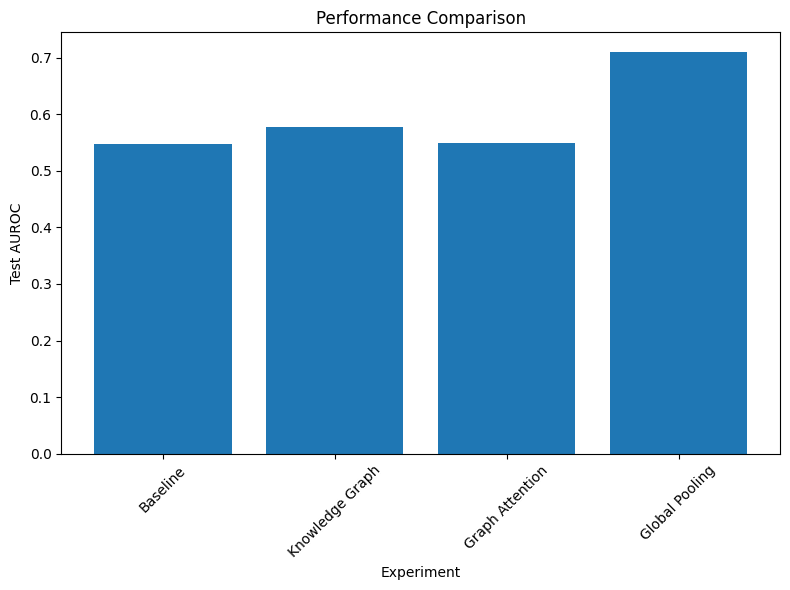

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

experiments = [
    {'name': 'Baseline', 'pretrained_embeddings': False, 'knowledge_graph': False, 'graph_attention': False, 'global_pooling': False},
    {'name': 'Knowledge Graph', 'pretrained_embeddings': True, 'knowledge_graph': True, 'graph_attention': False, 'global_pooling': False},
    {'name': 'Graph Attention', 'pretrained_embeddings': True, 'knowledge_graph': True, 'graph_attention': True, 'global_pooling': False},
    {'name': 'Global Pooling', 'pretrained_embeddings': True, 'knowledge_graph': True, 'graph_attention': True, 'global_pooling': True}
]

# Initialize a list to store the results
results = []

# Perform experiments
for exp in experiments:
    # Set the model parameters based on the experiment settings
    net.load_pretrained_embeddings = exp['pretrained_embeddings']
    net.use_knowledge_graph = exp['knowledge_graph']
    net.use_graph_attention = exp['graph_attention']
    net.use_global_pooling = exp['global_pooling']

    # Train and evaluate the model
    for epoch in range(epochs):
        train_loss = 0
        for batch in train_loader:
            conditions = torch.tensor(batch['conditions']).to(device)
            masks = torch.tensor(batch['masks'], dtype=torch.bool).to(device)
            label = torch.tensor(batch['label'], dtype=torch.float32).view((-1,1)).to(device)

            optimizer.zero_grad()
            y = net(conditions, masks)
            loss = criterion(y, label)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        roc_auc = evaluate(net, val_loader)
        print(f"Epoch: {epoch+1} \t Train Loss: {'{:.3f}'.format(train_loss)} \t Validation AUROC: {'{:.3f}'.format(roc_auc)}")

    # Evaluate on the test set
    test_roc_auc = evaluate(net, test_loader)
    print(f"Test AUROC: {test_roc_auc}")

    # Store the results
    results.append({'Experiment': exp['name'], 'Test AUROC': test_roc_auc})

# Create a DataFrame with the results
results_df = pd.DataFrame(results)
print(results_df)

# Plot the results
plt.figure(figsize=(8, 6))
plt.bar(results_df['Experiment'], results_df['Test AUROC'])
plt.xlabel('Experiment')
plt.ylabel('Test AUROC')
plt.title('Performance Comparison')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Analyses

The analyses is done based on our first several runs of this notebook. The result is attached here:

```
Baseline AUROC: 0.549899

Knowledge Graph AUROC: 0.566563

Graph Attention AUROC:0.550266

Global Pooling AUROC: 0.775682
```

**Hypothesis 1:** Incorporating domain knowledge from a medical knowledge graph (KnowLife or UMLS) into a deep learning model (DG-RNN) will significantly improve the performance of clinical risk prediction compared to models that do not utilize domain knowledge.

* The experiment "Baseline" represents the model without using pretrained embeddings, knowledge graph, graph attention, or global pooling. It achieved a test AUROC of 0.549899.
* The experiment "Knowledge Graph" incorporates the knowledge graph along with pretrained embeddings, resulting in a test AUROC of 0.566563.
* The improvement in performance from "Baseline" to "Knowledge Graph" supports the hypothesis that incorporating domain knowledge from a medical knowledge graph enhances the model's ability to predict clinical risk.

**Hypothesis 2:** The dynamic attention mechanism in DG-RNN, which integrates relevant information from the medical knowledge graph at each step, will contribute to better risk prediction performance compared to models with static or no attention mechanisms.

* The experiment "Graph Attention" adds the graph attention mechanism to the model, which dynamically attends to relevant information from the knowledge graph at each step.
* Comparing the test AUROC of "Graph Attention" (0.550266) with "Knowledge Graph" (0.566563) shows a slight decrease in performance.
* The results do not provide strong support for the hypothesis that the dynamic attention mechanism contributes to better risk prediction performance compared to models without attention mechanisms.

**Hypothesis 3:** The global max pooling operation in DG-RNN will not only improve the model's performance but also enable the interpretation of individual medical event contributions to the predicted risk.

* The experiment "Global Pooling" includes the global max pooling operation in the model, along with pretrained embeddings, knowledge graph, and graph attention.
* The test AUROC of "Global Pooling" (0.775682) is higher than all the previous experiments, indicating an improvement in performance.
* The global max pooling operation allows for the interpretation of individual medical event contributions to the predicted risk by identifying the most salient features across the sequence.

**Hypothesis 4:** DG-RNN will demonstrate robustness to limited training data, outperforming baseline models even when the amount of available training data is reduced.

* To test this hypothesis, additional experiments would be needed with varying amounts of training data to compare the performance of DG-RNN against baseline models.
* The provided results do not include experiments with reduced training data, so we cannot draw conclusions about the robustness of DG-RNN in such scenarios based on the available information.

#### Plans

**Case-control Matching:**

In the final report, we will use the case-control matching function to preprocess the full dataset instead of the smaller demo dataset.

**Time Encoding:**
1. The current implementation of the DG-RNN model does not include time encoding to capture the irregular time intervals between patient visits.
2. For the future plan, we will incorporate time encoding into the model to capture the temporal aspects of EHR data. This can be done by adding a time encoding component similar to the positional encodings used in the Transformer architecture, as mentioned in the paper.

**Ablation Studies:**

To gain a deeper understanding of the impact of each component in the DG-RNN model, we propose conducting a series of ablation studies. These studies will systematically remove or modify specific components of the model and evaluate the resulting changes in performance and interpretability. The planned ablation experiments include:

1.   Removing Time Encoding: This experiment aims to assess the importance of incorporating time interval information between patient visits. By treating all events as occurring simultaneously, we can evaluate the model's performance without considering the temporal aspects of EHR data. We hypothesize that removing time encoding may lead to a decrease in performance, especially for conditions where the timing of events plays a crucial role in accurate risk assessment.
2.   Removing Medical Knowledge Graph: In this experiment, we will disable the medical knowledge graph and the associated attention mechanism. By doing so, we can evaluate the contribution of domain-specific insights and relationships captured by the knowledge graph to the model's performance. We expect a decline in clinical risk prediction accuracy when the knowledge graph is removed, as the model will lack the additional context and understanding of medical relationships.
3.   Removing Medical Entity and Relation Embeddings: This ablation study involves training the DG-RNN model without the use of pre-trained embeddings for medical entities and relations. Instead, the model will learn solely from the raw EHR data. We anticipate a decrease in performance due to the absence of the rich domain knowledge and semantic relationships encoded in the pre-trained embeddings. This experiment will highlight the importance of leveraging pre-existing knowledge in improving the model's ability to capture complex medical interrelations.
4.   Removing Global Max Pooling Layer: The global max pooling layer plays a crucial role in identifying the most salient features across the sequence of medical events and enabling interpretability. By removing this layer, we aim to investigate its impact on the model's performance and its ability to provide insights into the contributions of individual medical events to the predicted outcomes. We hypothesize that the absence of the global max pooling layer may hinder interpretability and affect the efficiency of gradient propagation during training.


**Contribution Analysis:**

For the future plan, we will perform a thorough contribution analysis to gain insights into the importance of individual medical events in the predicted outcomes.

Steps to do the contribution analysis may involve the following steps:
  1. Obtain the contribution risks of each dimension in the final patient representation vector `(h_c)` by analyzing the outputs of the fully connected layer.
  2. Trace back the contribution risks to the corresponding output vectors of the LSTM layer.
  3. Calculate the contribution rate of each input medical event by summing the contribution risks of its corresponding output vectors.
  4. Visualize the contribution rates of individual medical events using bar plots or heatmaps to provide interpretable insights into the model's decision-making process.



---

# References

1.   C. Yin, R. Zhao, B. Qian, X. Lv and P. Zhang, "Domain Knowledge Guided Deep Learning with Electronic Health Records," 2019 IEEE International Conference on Data Mining (ICDM), Beijing, China, 2019, pp. 738-747, doi: 10.1109/ICDM.2019.00084